In [628]:
import a1
import numpy as np
import tensorflow as tf
import keras
from keras.datasets import mnist
import keras_tuner as kt
from tensorflow.keras.layers import Flatten, Dense, Dropout

tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Part 1.
In this part, we are going to use simple parameters to build a model and see it's performance. This part is more for me to go through to see if the model's performance and also epochs seem right before tuning hyper parameters.

***Part 2 has the main discussion point.***

## Data and Parameters

In [629]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [630]:
# Checking the shape of data
print(train_images.shape)
print(train_labels.shape)
print(test_labels.shape)
print(test_images.shape)

(60000, 28, 28)
(60000,)
(10000,)
(10000, 28, 28)


In [631]:
# Splitting the train_images and train_labels into 2 x sets for training and testing a model.
# We keep the test_images, test_labels data to validate the model.
x_train = train_images
x_val = test_images

y_train = train_labels
y_val = test_labels

In [632]:
# Converting the data so it has correct shape, data type, and value range before feeding to network.
x_train = np.expand_dims(x_train, -1).astype("float32") / 255.0
x_val = np.expand_dims(x_val, -1).astype("float32") / 255.0

In [633]:
#Simple version of the model. We first build a simple model to see it's performance.

# Output has 10 values (number 0 to 9)
num_categories = 10

# Using 'categorical_crossentropy'
y_train = keras.utils.to_categorical(y_train, num_categories)
y_val = keras.utils.to_categorical(y_val, num_categories)

#P re-defining parameters used in functions.
rows = 28
columns = 28
channels = 1
epochs = 5

# As a simple model, we are using below layers.
layer_options = [
    (128, 'relu', 0), # 128 neurons, relu activation, no dropout
    (128, 'relu', 0), # 128 neurons, relu activation, no dropout 
    (128, 'relu', 0.4), # 128 neurons, relu activation, no dropout
]

## Simple NN Model

In [635]:
# Building a model in this cell.
model = a1.build_deep_nn(rows, columns, channels, layer_options)

# Adding a final Dense layer for classification
model.add(keras.layers.Dense(num_categories, activation='softmax'))

In [636]:
model.compile(optimizer='adam',
              # Change loss to 'categorical_crossentropy'
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [637]:
# Confirming the model has been created with the passed params.
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1290      
                                                                 
Total params: 134,794
Trainable params: 134,794
Non-tr

In [638]:
# fitting the model with the test set with 15 epochs and batch size of 128.
# Interesting in determining the ideal epoch for the model.
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15, batch_size=128)

Epoch 1/15
469/469 [==============================] - 1s 2ms/step - loss: 0.3652 - accuracy: 0.8900 - val_loss: 0.1383 - val_accuracy: 0.9574
Epoch 2/15
469/469 [==============================] - 1s 2ms/step - loss: 0.1401 - accuracy: 0.9586 - val_loss: 0.1114 - val_accuracy: 0.9644
Epoch 3/15
469/469 [==============================] - 1s 2ms/step - loss: 0.0994 - accuracy: 0.9710 - val_loss: 0.0911 - val_accuracy: 0.9707
Epoch 4/15
469/469 [==============================] - 1s 2ms/step - loss: 0.0761 - accuracy: 0.9769 - val_loss: 0.0910 - val_accuracy: 0.9722
Epoch 5/15
469/469 [==============================] - 1s 2ms/step - loss: 0.0597 - accuracy: 0.9820 - val_loss: 0.0794 - val_accuracy: 0.9740
Epoch 6/15
469/469 [==============================] - 1s 2ms/step - loss: 0.0514 - accuracy: 0.9843 - val_loss: 0.0700 - val_accuracy: 0.9780
Epoch 7/15
469/469 [==============================] - 1s 2ms/step - loss: 0.0416 - accuracy: 0.9873 - val_loss: 0.0760 - val_accuracy: 0.9779
Epoch 

## Results of the Simple Model

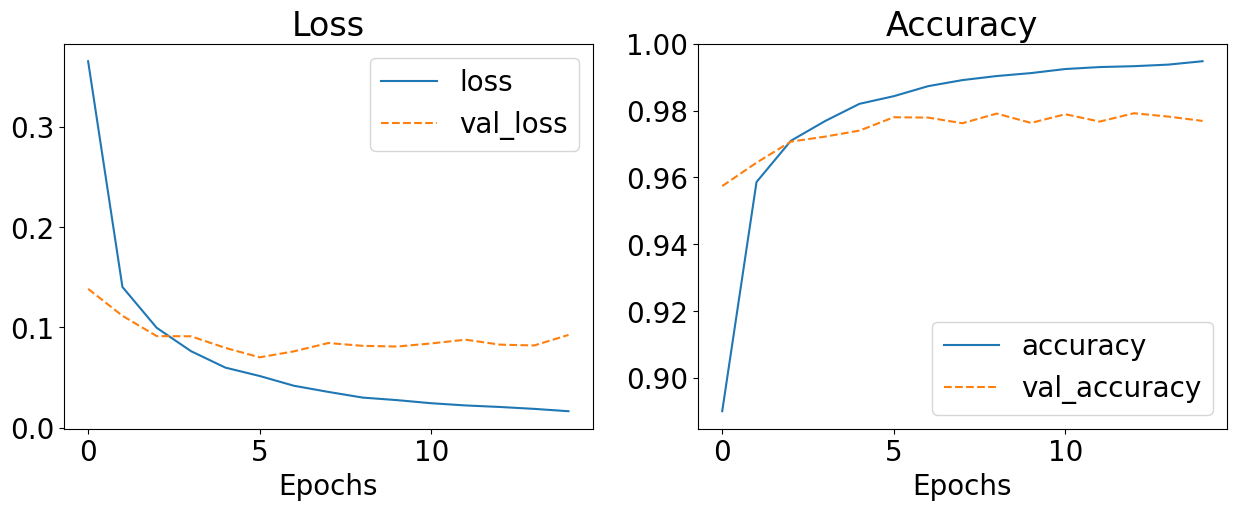

In [639]:
# Same as in the lecture, we are going to compare Loss and Accuracy with the ones from validation set.
# This function produces plots to comapre them.
def training_plot(metrics, history):
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots(1, len(metrics), figsize=(15, 5))
    
    if len(metrics) == 1:
        ax = [ax]

    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], label=metric)
        ax[idx].plot(history.history['val_' + metric], ls='dashed', label='val_' + metric)
        ax[idx].set_title(metric.capitalize())
        ax[idx].set_xlabel("Epochs")
        ax[idx].legend()

    plt.show()

    
training_plot(['loss', 'accuracy'], history)


### Comments:
In this simple model,
- We can see that the loss gets closer to 0 after 10 epochs in the left-hand plot.
- We can also see the gap between 'accuracy' and 'val_accuracy' starts becoming bigger around epoch 5.
- We can stick to epoch = 5
- Accuracy seems very high.

# Part 2.
## Hyper-Parameter Tuning

Now we are going to investigate on what parameters can be used to reach higher accuracy. Parameters that need tuning are given below:
- Number of hidden layers: 1 to 3.
- Size of the hidden layers
- Dropout rate of the final hidden layer

**We are asked to answer below:**
- What are the hyperparameters of the optimal model?
- What are the accuracy results of the optimal model on the test set? - To make this assignment easier, use the same data for the validation set and for the test set.


## Redefining the Params and Data

Just in case if the part 1 does not run.

In [665]:
# Import libraries in case there is something happened.
from tensorflow.keras import layers, models, optimizers
import keras_tuner as kt
import a1

# Redefining the data and updating the shapes
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

x_train = train_images
x_val = test_images

y_train = train_labels
y_val = test_labels

x_train = np.expand_dims(x_train, -1).astype("float32") / 255.0
x_val = np.expand_dims(x_val, -1).astype("float32") / 255.0

# Output has 10 values (number 0 to 9)
num_categories = 10

# Using 'categorical_crossentropy'
y_train = keras.utils.to_categorical(y_train, num_categories)
y_val = keras.utils.to_categorical(y_val, num_categories)

### Defining HyperParameter Searching Function

- Using the function we built in the earlier task (a1.py), we explore what parameters best perform.
- This function goes through the possible combination of layers, functions and dropouts.

In [685]:
def build_model(hp):
    # Define the input shape
    rows, columns, channels = 28, 28, 1  # Assuming this input shape

    # Hyperparameters for each layer
    layer_options = []

    # Tune the number of layers
    num_layers = hp.Int("num_layers", 1, 3)
    
    for i in range(num_layers):
        # Tune the number of units in each layer
        hidden_size = hp.Int(f"units_{i}", min_value=32, max_value=512, step=32)
        # Tune the activation function
        activation = hp.Choice(f"activation_{i}", ["relu", "tanh"])
        # Tune the dropout rate
        dropout_rate = hp.Float(f"dropout_rate_{i}", min_value=0.0, max_value=0.9, step=0.1)
        layer_options.append((hidden_size, activation, dropout_rate)) 

    # Build the model using the build_deep_nn() from a1.py (task 1.3)
    model = build_deep_nn(rows, columns, channels, layer_options)

    # Output layer (10 outputs)
    model.add(layers.Dense(10, activation="softmax"))

    # Defining learning rate
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")

    # I'm using legacy.Adam instead as system warned "to run this on M1/M2, legacy is better"
    model.compile(
        optimizer=optimizers.legacy.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

## Define RandomSearch

In here, we define metrics, number of trials, how many executions a trial has, and directory and file name that are used to save the trial results.

In [715]:
# Usage with KerasTuner
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=2,
    directory="tuning",
    project_name="deep_nn_tuning",
)

## Searching Optimal HyperParameters

In [716]:
tuner.search(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

Trial 10 Complete [00h 00m 24s]
val_accuracy: 0.943200021982193

Best val_accuracy So Far: 0.9791500270366669
Total elapsed time: 00h 06m 20s


## Top Performing HyperParameters

Based on the result returned by keras_tuner, we can say that the best performing hyperparameters are displayed in the cell below.

In [722]:
print(tuner.results_summary(1))

Results summary
Results in tuning/deep_nn_tuning
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 03 summary
Hyperparameters:
num_layers: 1
units_0: 416
activation_0: relu
dropout_rate_0: 0.4
learning_rate: 0.0011567215009185543
units_1: 192
activation_1: tanh
dropout_rate_1: 0.5
units_2: 128
activation_2: relu
dropout_rate_2: 0.0
Score: 0.9791500270366669
None


## Model Tuning with the HyperParameters

In [723]:
# Getting the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# Build the model with the optimal hyperparameters
tuned_model = build_model(best_hps)

tuned_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 416)               326560    
                                                                 
 dropout_3 (Dropout)         (None, 416)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                4170      
                                                                 
Total params: 330,730
Trainable params: 330,730
Non-trainable params: 0
_________________________________________________________________


## Performance of Tuned Model

Below shown is the performance of the tuned model on test dataset. We can see that the accuracy has reached to nearly 96%. However, the accuracy has dropped when comparing to the one on training set so it's hard to believe there is overfitting.

In [724]:
tuned_model.fit(x_val, y_val, epochs=5, batch_size=128)

Epoch 1/5
79/79 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.8182
Epoch 2/5
79/79 [==============================] - 0s 3ms/step - loss: 0.2864 - accuracy: 0.9155
Epoch 3/5
79/79 [==============================] - 0s 3ms/step - loss: 0.2099 - accuracy: 0.9389
Epoch 4/5
79/79 [==============================] - 0s 3ms/step - loss: 0.1711 - accuracy: 0.9495
Epoch 5/5
79/79 [==============================] - 0s 3ms/step - loss: 0.1408 - accuracy: 0.9580
